In [ ]:
"""
Title: Timeseries classification with a Transformer model
Author: [Theodoros Ntakouris](https://github.com/ntakouris)
Date created: 2021/06/25
Last modified: 2021/08/05
Description: This notebook demonstrates how to do timeseries classification using a Transformer model.
Accelerator: GPU
"""

"""
## Introduction

This is the Transformer architecture from
[Attention Is All You Need](https://arxiv.org/abs/1706.03762),
applied to timeseries instead of natural language.

This example requires TensorFlow 2.4 or higher.
"""

'\n## Introduction\n\nThis is the Transformer architecture from\n[Attention Is All You Need](https://arxiv.org/abs/1706.03762),\napplied to timeseries instead of natural language.\n\nThis example requires TensorFlow 2.4 or higher.\n'

In [ ]:
import numpy as np
import keras
from keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
import json
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
import pickle
from google.colab import drive

drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/combined_all_interpol_synced_4sec_800samples_prot4.pkl'
"""
def calculate_duration(row):
    timestamps = row['timestamp.GYR']
    duration = (timestamps[-1] - timestamps[0]) * 1e-9  # Convert from nanoseconds to seconds
    return duration

dataFrame = pd.read_pickle(file_path)
dataFrame = dataFrame.dropna()

dataFrame['duration'] = dataFrame.apply(calculate_duration, axis=1)

dataFrame = dataFrame.drop(columns=['mid', 'counter'])
dataFrame = dataFrame.drop(columns= [x for x in dataFrame.columns if 'timestamp.' in x])
"""
dataFrame = pd.read_pickle(file_path)


print(dataFrame.columns)
y = np.array(dataFrame['uid'])
x = None
for col in dataFrame.columns:
    if 'sensordata' in col:
        if x is None:
            x = np.array(dataFrame[col].apply(lambda x: np.array(x)).to_list())
            #print(x_data.shape)
        else:
            x_data = np.array(dataFrame[col].apply(lambda x: np.array(x)).to_list())
            #print(x_data.shape)
            x = np.append(x, x_data , axis=2)
dur = np.array(dataFrame['duration'])
print("Dataset shapes: ")
print(x.shape)
print(dur.shape)
print(y.shape)


def split_features_and_adjust_labels(x, y, window_size=100, overlap=0.4):
    num_samples = x.shape[0]
    num_timesteps = x.shape[1]
    num_features = x.shape[2]

    step_size = int(window_size * (1 - overlap))
    num_segments = int((num_timesteps - window_size) / step_size) + 1

    split_x = np.zeros((num_samples * num_segments, window_size, num_features))
    adjusted_y = np.repeat(y, num_segments)

    segment_index = 0
    for sample_index in range(num_samples):
        for i in range(0, num_timesteps - window_size + 1, step_size):
          split_x[segment_index] = x[sample_index, i : i + window_size, :]
          segment_index += 1

    return split_x, adjusted_y, num_segments

def get_aligned_and_rest(split_x, adjusted_y,num_segments):
    x_aligned = []
    y_aligned = []
    x_other = []
    y_other = []

    for i in range(len(adjusted_y)):
        if i % num_segments == 0:
            x_aligned.append(split_x[i])
            y_aligned.append(adjusted_y[i])
        else:
            x_other.append(split_x[i])
            y_other.append(adjusted_y[i])
    return np.array(x_aligned), np.array(y_aligned), np.array(x_other), np.array(y_other)


split_x, adjusted_y,num_segments  = split_features_and_adjust_labels(x,y,window_size=100,overlap=0)
print(split_x.shape, adjusted_y.shape)
x_aligned, y_aligned, x_other, y_other = get_aligned_and_rest(split_x,adjusted_y, num_segments)

x = x_aligned
y = y_aligned


Index(['uid', 'sensordata.ACC', 'sensordata.GYR', 'sensordata.GRV',
       'sensordata.MAG', 'sensordata.ROT', 'duration'],
      dtype='object', name='stype')
Dataset shapes: 
(332, 800, 17)
(332,)
(332,)
(2656, 100, 17) (2656,)


In [ ]:
print(x_aligned.shape, y_aligned.shape)
print(x_other.shape, y_other.shape)

(332, 100, 17) (332,)
(2324, 100, 17) (2324,)


In [ ]:

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

y_aligned = y_aligned.astype(str)
y_other = y_other.astype(str)

class_label_encoder = LabelEncoder()
scaler = StandardScaler()

y = class_label_encoder.fit_transform(y)
y_other = class_label_encoder.transform(y_other)
n_classes = class_label_encoder.classes_.shape[0]

print("train-test shapes: ")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

x_other_scaled = scaler.transform(x_other.reshape(-1, x_other.shape[-1])).reshape(x_other.shape)


print(x_other_scaled.shape, y_other.shape)

train-test shapes: 
(232, 100, 17) (100, 100, 17) (232,) (100,)
(232, 100, 17) (100, 100, 17) (232,) (100,)
(2324, 100, 17) (2324,)


In [ ]:
# prompt: I want learnable positional encodings

import tensorflow as tf

class LearnablePositionalEncoding(layers.Layer):
    def __init__(self, max_position_encoding, d_model):
        super(LearnablePositionalEncoding, self).__init__()
        self.pos_embedding = tf.Variable(tf.random.normal((1, max_position_encoding, d_model)))

    def call(self, x):
        sequence_length = tf.shape(x)[1]
        return x + self.pos_embedding[:, :sequence_length, :]

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)



In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    pos_encoding = positional_encoding(inputs.shape[1], inputs.shape[2])
    encoded_inputs = inputs + pos_encoding[:, :inputs.shape[1], :]
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(encoded_inputs, encoded_inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + encoded_inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res
def build_model(
    input_shape,
    n_classes,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    # Output layer for classification
    outputs = layers.Dense(n_classes, activation="softmax")(x)

    # Full model (including output layer)
    full_model = keras.Model(inputs, outputs)

    # Encoder model (before output layer, i.e., after pooling)
    encoder_model = keras.Model(inputs, x)

    return full_model, encoder_model


In [ ]:

def transformer_encoder_dense(inputs, head_size, num_heads, ff_dim, dropout=0):
    pos_encoding = positional_encoding(inputs.shape[1], inputs.shape[2])
    encoded_inputs = inputs + pos_encoding[:, :inputs.shape[1], :]
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(encoded_inputs, encoded_inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + encoded_inputs

    # Feed Forward Part
    x = layers.Dense(ff_dim, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_model_dense(
    input_shape,
    n_classes,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder_dense(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    # Output layer for classification
    outputs = layers.Dense(n_classes, activation="softmax")(x)

    # Full model (including output layer)
    full_model = keras.Model(inputs, outputs)

    # Encoder model (before output layer, i.e., after pooling)
    encoder_model = keras.Model(inputs, x)

    return full_model, encoder_model


In [ ]:
MPATH = '/content/drive/MyDrive/dec9/small_seg100_nooverlap_aligned_transformer_not_dense_model'
input_shape = x_train.shape[1:]
class SaveModelCheckpoint(keras.callbacks.Callback):
    def __init__(self, filepath, interval=10):
        super(SaveModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            filepath = self.filepath.format(epoch=epoch + 1)
            # Create the directory if it doesn't exist
            os.makedirs(os.path.dirname(filepath), exist_ok=True)
            self.model.save(filepath + '.keras')
            print(f"Saving model to {filepath}")
    def on_train_end(self, logs=None):
        filepath = self.filepath.format(epoch="0")
        # Create the directory if it doesn't exist
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        print(f"Saving history to {filepath}")
        with open(self.filepath+'.json', 'a') as f:
            json.dump(self.model.history.history, f, indent=4)



# Create an instance of the custom callback
save_checkpoint_callback = SaveModelCheckpoint(MPATH +'_{epoch}', interval=10)

callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True), save_checkpoint_callback]

In [ ]:
model,encoder = build_model(
    input_shape,
    n_classes=n_classes,
    head_size=32,
    num_heads=6,
    ff_dim=64,
    num_transformer_blocks=6,
    mlp_units=[32],
    mlp_dropout=0.2,
    dropout=0.2,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()


NameError: name 'build_model' is not defined

In [ ]:
# prompt: print available gpus for tensorflow

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
with tf.device('/device:GPU:0'):
  model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=4,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)
model.save(MPATH+'.keras')

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 72s 599ms/step - loss: 3.8286 - sparse_categorical_accuracy: 0.1108 - val_loss: 2.4287 - val_sparse_categorical_accuracy: 0.0638
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 28ms/step - loss: 2.6750 - sparse_categorical_accuracy: 0.1496 - val_loss: 2.1611 - val_sparse_categorical_accuracy: 0.2340
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.2865 - sparse_categorical_accuracy: 0.2169 - val_loss: 2.0195 - val_sparse_categorical_accuracy: 0.2553
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 1.9265 - sparse_categorical_accuracy: 0.3668 - val_loss: 1.8395 - val_sparse_categorical_accuracy: 0.3830
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6536 - sparse_categorical_accuracy: 0.4377 - val_loss: 1.6562 - val_sparse_categorical_accuracy: 0.4043
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7983 - sparse_categorical_accuracy: 0.3874 - val_loss: 1.7910 - val_sparse_categorical_accuracy: 0.4255
E

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 100, 17)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 100, 17)        │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 100, 17)        │         18,193 │ add_2[0][0],           │
│ (MultiHeadAttention)      │                        │                │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 100, 17)        │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 100, 17)        │             34 │ dropout_3[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 100, 17)        │              0 │ layer_normalization_1… │
│                           │                        │                │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 100, 64)        │          1,152 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 100, 64)        │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 100, 17)        │          1,105 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 100, 17)        │             34 │ dense_1[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 100, 17)        │              0 │ layer_normalization_2… │
│                           │                        │                │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 100, 17)        │              0 │ add_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 100, 17)        │         18,193 │ add_5[0][0],           │
│ (MultiHeadAttention)      │                        │                │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 100, 17)        │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 100, 17)        │             34 │ dropout_6[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)          

 Total params: 251,819 (983.67 KB)

 Trainable params: 83,939 (327.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 167,880 (655.79 KB)

In [ ]:
loadPath = '/content/drive/MyDrive/dec9/small_seg100_nooverlap_aligned_transformer_not_dense_model'
model = tf.keras.models.load_model(loadPath + '.keras')


In [ ]:
encoder = keras.Model(inputs=model.input, outputs=model.layers[-3].output)

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


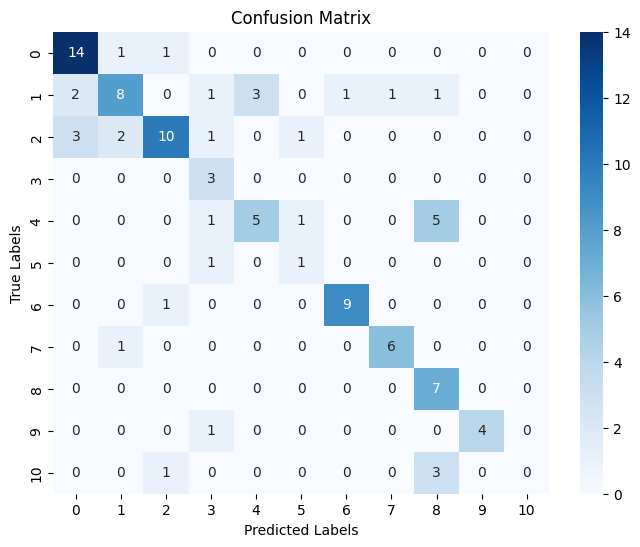

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.74      0.88      0.80        16
           1       0.67      0.47      0.55        17
           2       0.77      0.59      0.67        17
           3       0.38      1.00      0.55         3
           4       0.62      0.42      0.50        12
           5       0.33      0.50      0.40         2
           6       0.90      0.90      0.90        10
           7       0.86      0.86      0.86         7
           8       0.44      1.00      0.61         7
           9       1.00      0.80      0.89         5
          10       0.00      0.00      0.00         4

    accuracy                           0.67       100
   macro avg       0.61      0.67      0.61       100
weighted avg       0.69      0.67      0.66       100

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step   
              precision    recall  f1-score   support

           0       0.74      0.88      0.80        16
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
pred = model.predict(x_test)
predicted_classes = np.argmax(pred, axis=1)
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(n_classes), yticklabels=np.arange(n_classes))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(sklearn.metrics.classification_report(y_test, predicted_classes))
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import sklearn

scaler = StandardScaler()

svm_model = SVC()
transformed_x_train = encoder.predict(x_train)
transformed_x_test = encoder.predict(x_test)
transformed_x_train = scaler.fit_transform(transformed_x_train)
transformed_x_test = scaler.transform(transformed_x_test)


svm_model.fit(transformed_x_train, y_train)
print(sklearn.metrics.classification_report(y_test, svm_model.predict(transformed_x_test)))

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step   


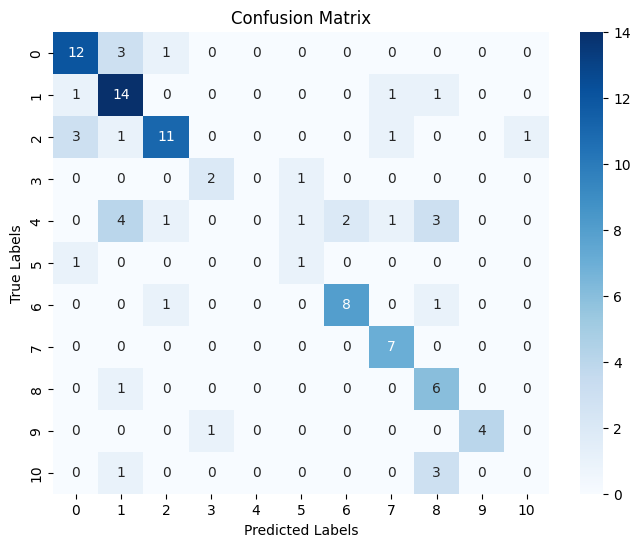

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.71      0.75      0.73        16
           1       0.58      0.82      0.68        17
           2       0.79      0.65      0.71        17
           3       0.67      0.67      0.67         3
           4       0.00      0.00      0.00        12
           5       0.33      0.50      0.40         2
           6       0.80      0.80      0.80        10
           7       0.70      1.00      0.82         7
           8       0.43      0.86      0.57         7
           9       1.00      0.80      0.89         5
          10       0.00      0.00      0.00         4

    accuracy                           0.65       100
   macro avg       0.55      0.62      0.57       100
weighted avg       0.58      0.65      0.60       100

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 474ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        16


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


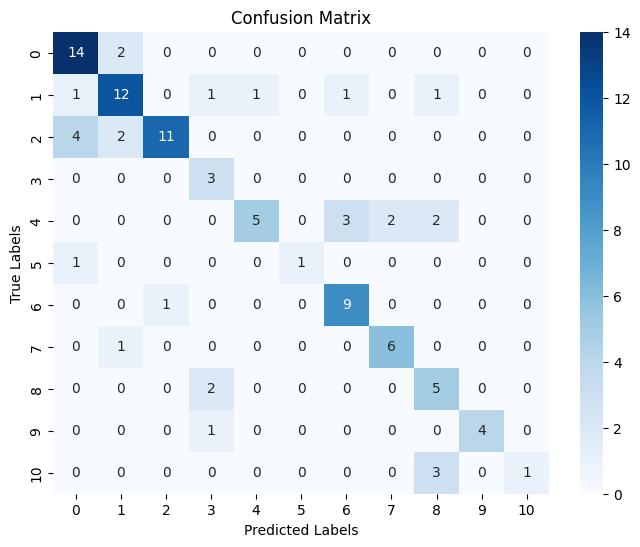

              precision    recall  f1-score   support

           0       0.70      0.88      0.78        16
           1       0.71      0.71      0.71        17
           2       0.92      0.65      0.76        17
           3       0.43      1.00      0.60         3
           4       0.83      0.42      0.56        12
           5       1.00      0.50      0.67         2
           6       0.69      0.90      0.78        10
           7       0.75      0.86      0.80         7
           8       0.45      0.71      0.56         7
           9       1.00      0.80      0.89         5
          10       1.00      0.25      0.40         4

    accuracy                           0.71       100
   macro avg       0.77      0.70      0.68       100
weighted avg       0.76      0.71      0.71       100

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        16
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
pred = model.predict(x_test)
predicted_classes = np.argmax(pred, axis=1)
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(n_classes), yticklabels=np.arange(n_classes))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(sklearn.metrics.classification_report(y_test, predicted_classes))
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import sklearn

scaler = StandardScaler()

svm_model = SVC()
transformed_x_train = encoder.predict(x_train)
transformed_x_test = encoder.predict(x_test)
transformed_x_train = scaler.fit_transform(transformed_x_train)
transformed_x_test = scaler.transform(transformed_x_test)


svm_model.fit(transformed_x_train, y_train)
print(sklearn.metrics.classification_report(y_test, svm_model.predict(transformed_x_test)))

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


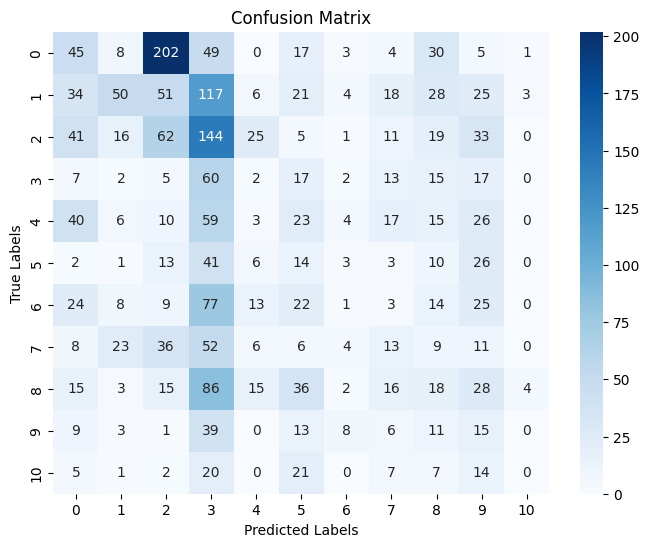

              precision    recall  f1-score   support

           0       0.20      0.12      0.15       364
           1       0.41      0.14      0.21       357
           2       0.15      0.17      0.16       357
           3       0.08      0.43      0.14       140
           4       0.04      0.01      0.02       203
           5       0.07      0.12      0.09       119
           6       0.03      0.01      0.01       196
           7       0.12      0.08      0.09       168
           8       0.10      0.08      0.09       238
           9       0.07      0.14      0.09       105
          10       0.00      0.00      0.00        77

    accuracy                           0.12      2324
   macro avg       0.12      0.12      0.10      2324
weighted avg       0.15      0.12      0.12      2324

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
              precision    recall  f1-score   support

           0       0.26      0.03      0.05       364


In [ ]:
# pred on not aligned
pred = model.predict(x_other)
predicted_classes = np.argmax(pred, axis=1)
cm = confusion_matrix(y_other, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(n_classes), yticklabels=np.arange(n_classes))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(sklearn.metrics.classification_report(y_other, predicted_classes))
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import sklearn

svm_model = SVC()
transformed_x_train = encoder.predict(x_train)
transformed_x_test = encoder.predict(x_other)
svm_model.fit(transformed_x_train, y_train)
print(sklearn.metrics.classification_report(y_other, svm_model.predict(transformed_x_test)))

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


tsne = TSNE(n_components=2, random_state=42)
pca = PCA(n_components=2)
lda = LinearDiscriminantAnalysis(n_components=2)
x_train_flat = x_train.reshape(x_train.shape[0], -1)
print(x_train_flat.shape)

tsne_results2 = tsne.fit_transform(x_train_flat)
pca_results2 = pca.fit_transform(x_train_flat)
lda_results2 = lda.fit_transform(x_train_flat, y_train)

(1859, 1700)


In [ ]:
tsne1 = TSNE(n_components=3, random_state=42)
pca1 = PCA(n_components=3)
lda1 = LinearDiscriminantAnalysis(n_components=3)
x_train_encoded = encoder.predict(x_train)

print(x_train_flat.shape)

tsne_results1 = tsne1.fit_transform(x_train_encoded)
pca_results1 = pca1.fit_transform(x_train_encoded)
lda_results1 = lda1.fit_transform(x_train_encoded, y_train)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
(1859, 1700)


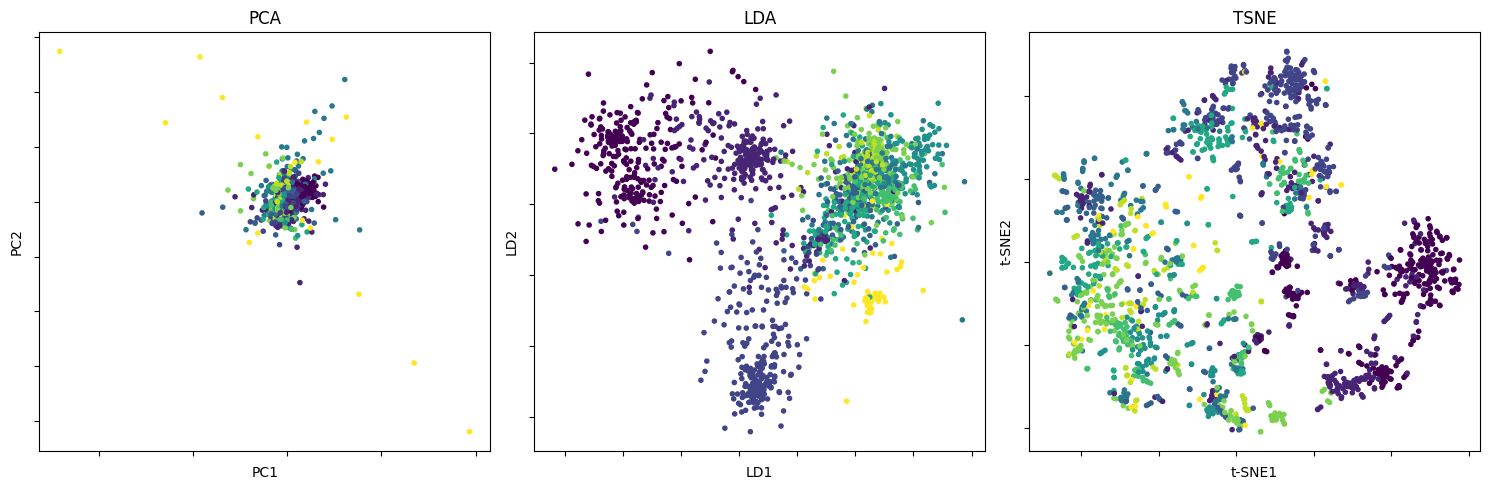

In [ ]:
pca_results = pca_results2
tsne_results = tsne_results2
lda_results = lda_results2
cmp = y_train

fig = plt.figure(figsize=(15,5))
fig.add_subplot(131)
plt.scatter(pca_results[:,0], pca_results[:,1], c=cmp,marker='.', cmap='viridis')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_xlabel('PC1')
plt.gca().set_ylabel('PC2')
plt.title('PCA')


fig.add_subplot(132)
plt.scatter(lda_results[:,0], lda_results[:,1], c=cmp,marker='.', cmap='viridis')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_xlabel('LD1')
plt.gca().set_ylabel('LD2')
plt.title('LDA')

fig.add_subplot(133)
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cmp,marker='.', cmap='viridis')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_xlabel('t-SNE1')
plt.gca().set_ylabel('t-SNE2')
plt.title('TSNE')
plt.tight_layout()


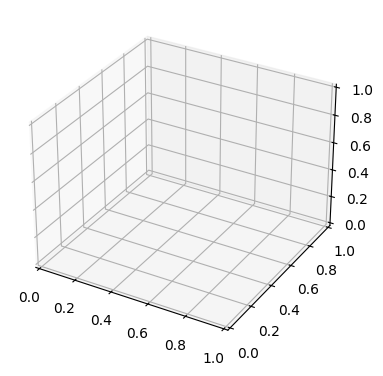

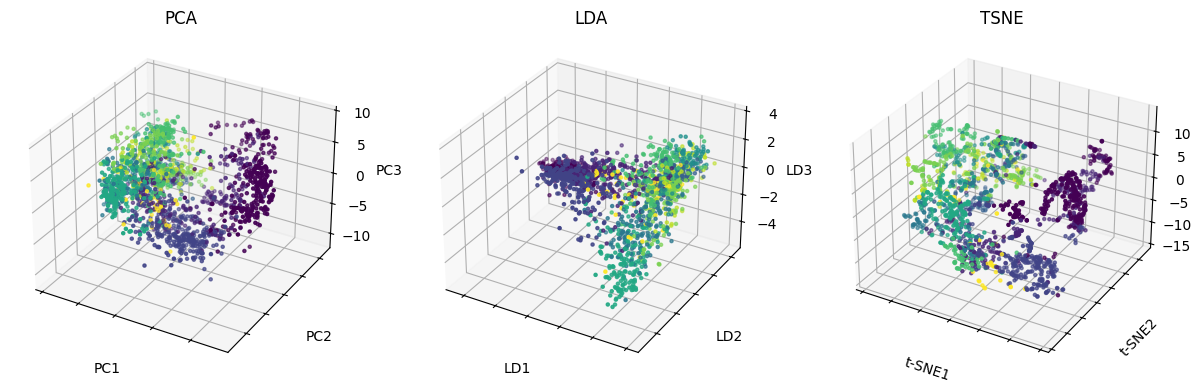

In [ ]:
pca_results = pca_results1
tsne_results = tsne_results1
lda_results = lda_results1
cmp = y_train

fig = plt.figure(figsize=(15, 5))

# PCA Plot (3D)
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(pca_results[:, 0], pca_results[:, 1], pca_results[:, 2], c=cmp, marker='.', cmap='viridis')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('PCA')

# LDA Plot (3D) - Assuming lda_results has 3 components
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(lda_results[:, 0], lda_results[:, 1], lda_results[:, 2], c=cmp, marker='.', cmap='viridis')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xlabel('LD1')
ax2.set_ylabel('LD2')
ax2.set_zlabel('LD3')
ax2.set_title('LDA')

# t-SNE Plot (3D) - Assuming tsne_results has 3 components
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], c=cmp, marker='.', cmap='viridis')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.set_xlabel('t-SNE1')
ax3.set_ylabel('t-SNE2')
ax3.set_zlabel('t-SNE3')
ax3.set_title('TSNE')

plt.tight_layout()
plt.show()

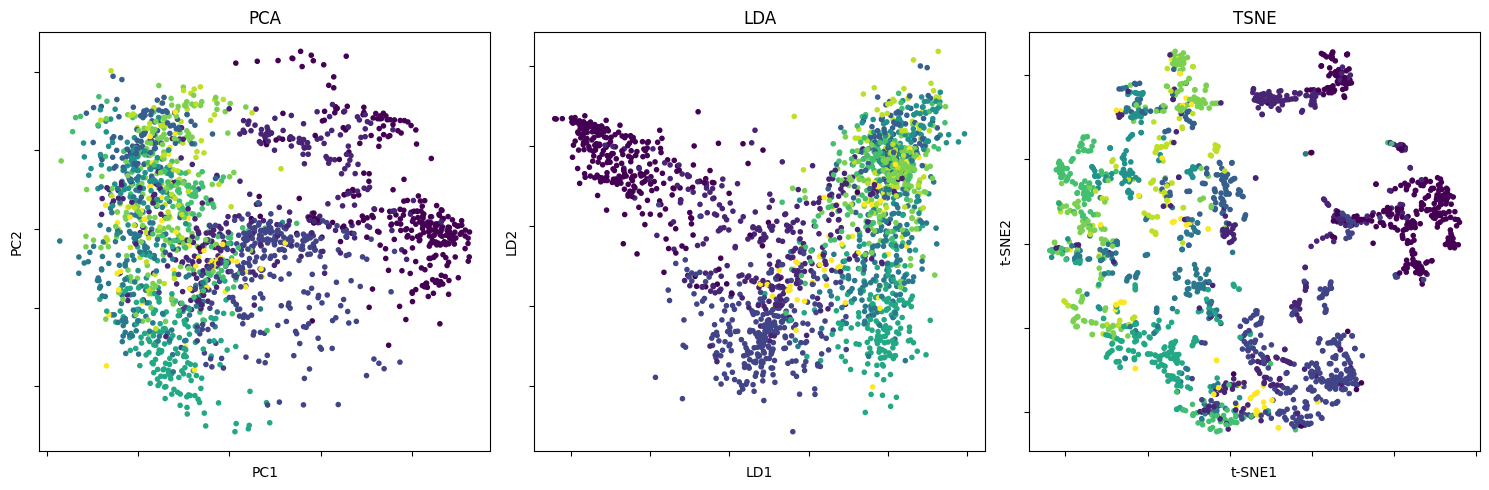

13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step


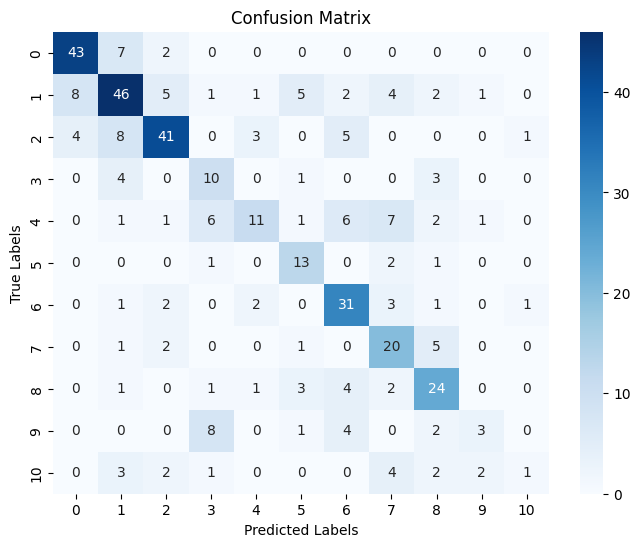

              precision    recall  f1-score   support

           0       0.78      0.83      0.80        52
           1       0.64      0.61      0.63        75
           2       0.75      0.66      0.70        62
           3       0.36      0.56      0.43        18
           4       0.61      0.31      0.41        36
           5       0.52      0.76      0.62        17
           6       0.60      0.76      0.67        41
           7       0.48      0.69      0.56        29
           8       0.57      0.67      0.62        36
           9       0.43      0.17      0.24        18
          10       0.33      0.07      0.11        15

    accuracy                           0.61       399
   macro avg       0.55      0.55      0.53       399
weighted avg       0.61      0.61      0.59       399

30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        52


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step


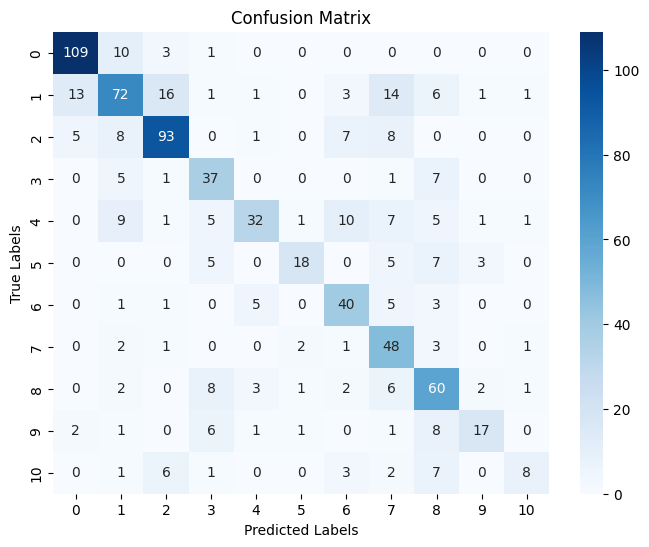

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       123
           1       0.65      0.56      0.60       128
           2       0.76      0.76      0.76       122
           3       0.58      0.73      0.64        51
           4       0.74      0.44      0.56        72
           5       0.78      0.47      0.59        38
           6       0.61      0.73      0.66        55
           7       0.49      0.83      0.62        58
           8       0.57      0.71      0.63        85
           9       0.71      0.46      0.56        37
          10       0.67      0.29      0.40        28

    accuracy                           0.67       797
   macro avg       0.67      0.62      0.63       797
weighted avg       0.69      0.67      0.66       797

59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       1

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 564ms/step


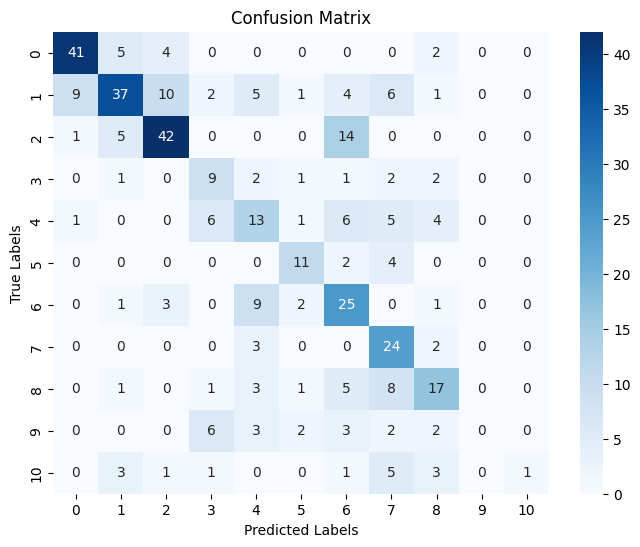

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        52
           1       0.71      0.56      0.63        75
           2       0.74      0.81      0.77        62
           3       0.52      0.67      0.59        18
           4       0.45      0.42      0.43        36
           5       0.50      0.76      0.60        17
           6       0.58      0.61      0.60        41
           7       0.56      0.76      0.65        29
           8       0.48      0.58      0.53        36
           9       0.57      0.22      0.32        18
          10       0.33      0.07      0.11        15

    accuracy                           0.63       399
   macro avg       0.57      0.57      0.55       399
weighted avg       0.62      0.63      0.61       399

